In [1]:
import gym
import numpy as np
import random
import copy 
import time
from matplotlib import pyplot as plt
from numpy.core.fromnumeric import argmax

# Working Code From Here

In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import copy

# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()

class Model():
  def __init__(self):
    self.transitions = [[[0 for i in range(3)] for j in range(15)] for k in range(19)]
    self.rewards = np.zeros((19,15,3))

  def add(self,s,a,s_prime,r):
    self.transitions[s[0]][s[1]][a] = s_prime
    self.rewards[s[0],s[1],a] = r

  def sample(self):
    """ Return random state, action"""
    # Random visited state
    x = np.where(self.rewards!=0)
    c = np.random.randint(0,len(x[0]))
    pos = x[0][c]
    vel = x[1][c]
    a   = x[2][c]
    ##print(pos,vel,a,self.transitions[pos][vel][a])
    return (pos,vel),a

  def step(self, s,a):
    """ Return state_prime and reward for state-action pair"""
    s_prime = self.transitions[s[0]][s[1]][a]
    r = self.rewards[s[0],s[1],a]

    return s_prime, r

def planning(n,model,states):
  for i in range(n):
    ##print(model)
    s, a = model.sample()
    nexts , reward = model.step(s,a)
    ##print(s,a,nexts,reward)
    states[s[0],s[1],a] = states[s[0],s[1],a] + 0.01*(reward + 0.95*(np.max(states[nexts[0],nexts[1]])) - states[s[0],s[1],a])
    #print(states)
  return states



def dynaqcar(env, learning, discount, episodes,n):
    
    num_states = (env.observation_space.high - env.observation_space.low)*np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    
    #Q = np.random.uniform(low = -1, high = 1, size = (num_states[0], num_states[1],env.action_space.n))
    Q = np.zeros((num_states[0], num_states[1], env.action_space.n))
    
    reward_list = []
    ave_reward_list = []
    
    m = Model()
    
    
    
    for i in range(episodes):
        
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        steps = 0
        epsilon = 0.01 * 0.99**(i)
       
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
        old_q = copy.deepcopy(Q)
        
        while tot_reward>-1000:   
           
            steps+=1

            if i >= (episodes):
                env.render()
                
            
            if np.random.random() > epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
                
            
            state2, reward, _, info = env.step(action) 
            
            
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            
            if  state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                tot_reward += 0
                done = True
                break
            
            else:
                delta = learning*(reward + discount*np.max(Q[state2_adj[0], state2_adj[1]]) - Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                tot_reward+=-1                    
            
            
            m.add(state_adj,action,state2_adj,reward)
            Q = planning(n,m,Q)
            state_adj = state2_adj
        

        reward_list.append(tot_reward)
       
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
        
        
            
    env.close()
    
    return ave_reward_list


rs = []
ps = []
ts = []
td  = []
for j in range(1,52,5):
    s = time.time()
    print('\n For' , j , 'Planning steps\n')
    rewards = dynaqcar(env, 0.1, 0.95, 500,j)
    st = np.mean(rewards)
    td.append(time.time()-s)
    rs.append(-1*st)
    ps.append(-1*st*j)
    ts.append(-1*st*(j+1))
   
  




D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



 For 1 Planning steps

Episode 100 Average Reward: -843.04
Episode 200 Average Reward: -409.68
Episode 300 Average Reward: -284.39
Episode 400 Average Reward: -265.09
Episode 500 Average Reward: -212.94

 For 6 Planning steps

Episode 100 Average Reward: -612.28
Episode 200 Average Reward: -335.19
Episode 300 Average Reward: -260.14
Episode 400 Average Reward: -194.98
Episode 500 Average Reward: -205.1

 For 11 Planning steps

Episode 100 Average Reward: -612.36
Episode 200 Average Reward: -237.83
Episode 300 Average Reward: -232.69
Episode 400 Average Reward: -211.87
Episode 500 Average Reward: -182.74

 For 16 Planning steps

Episode 100 Average Reward: -633.69
Episode 200 Average Reward: -227.74
Episode 300 Average Reward: -227.25
Episode 400 Average Reward: -211.19
Episode 500 Average Reward: -165.71

 For 21 Planning steps

Episode 100 Average Reward: -375.0
Episode 200 Average Reward: -220.87
Episode 300 Average Reward: -259.83
Episode 400 Average Reward: -219.18
Episode 500 Ave

In [3]:
import copy
import gym
import numpy as np


def reinforcement(env,n, gamma, thresh):
    env = gym.make('MountainCar-v0')
    env = env.unwrapped
    env.reset()
    rewards = np.zeros((19,15))
    policy = np.zeros((19,15))
    for _ in range(n):
        old_reward = copy.deepcopy(rewards)
        for i in range(19):
            for j in range(15):
                total = []
                curr = np.round(np.array([i,j])/np.array([10, 100]) + env.observation_space.low,2)
                
                for a in range(3):
                    env.reset()
                    env.state = curr
                    s_next,reward,done,info = env.step(a)

                    ##print(curr,s_next,reward,done)
                    s_next = (s_next - env.observation_space.low)*np.array([10, 100])
                    s_next = np.round(s_next, 0).astype(int)
                    if done:
                        total.append(10)
                    else :
                        total.append(gamma*old_reward[s_next[0]][s_next[1]])
                ##print(total)

                rewards[i][j] = np.max(total)
                if np.all(np.abs(rewards[i][j]-total)<1e-3):
                    policy[i][j] = int(np.random.randint(0,3))
                    rewards[i][j] = total[int(policy[i][j])]
                else:    
                    policy[i][j] = argmax(total)
        #print(rewards)
        '''if np.all(np.abs(old_reward-rewards) < thresh):
            print('Cutoff')
            return rewards'''
    return rewards,policy

env = gym.make('MountainCar-v0')
env = env.unwrapped
env.reset()

reinforcement(env,35,0.8,1e-10)

(array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.22517998,  0.22517998],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.28147498,  0.28147498],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.35184372,  0.35184372],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.43980465,  0.43980465],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,

In [4]:
import numpy as np
import gym
import matplotlib.pyplot as plt


env = gym.make('MountainCar-v0')
env.reset()

def upstates(states,pseudorewards,policy,shapes):
  for i in range(shapes[0]):
    for j in range(shapes[1]):
      if policy[i][j]!= 'NA':
        states[i][j][int(policy[i][j])]= pseudorewards[i][j]
  return states

def mbpa(env, learning, discount, episodes,value):

    num_states = (env.observation_space.high - env.observation_space.low)*np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1

    Q = np.zeros((num_states[0], num_states[1], env.action_space.n))
 
    reward_list = []
    ave_reward_list = []

    new_reward, policy = reinforcement(env,value,0.95,1e-10)

    Q = upstates(Q,new_reward,policy,(19,15))

    for i in range(episodes):
       
        done = False
        steps = 0
        tot_reward, reward = 0,0
        state = env.reset()
        epsilon = 0.01 * 0.99**(i)
        old_q = copy.deepcopy(Q)
       
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
    
        while done != True:   
   
            if np.random.random() >= epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
            
            state2, reward, _, info = env.step(action) 
            
            
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            
            if  state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = 0
                tot_reward += 0
                done = True
            else:
                reward = reward + new_reward[state2_adj[0], state2_adj[1]]
                delta = learning*(reward + discount*np.max(Q[state2_adj[0], state2_adj[1]]) - Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                tot_reward += -1  
            
            
            state_adj = state2_adj
        
       
        reward_list.append(tot_reward)
       
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))

        
            
    env.close()
    print(np.round(np.mean(ave_reward_list)*1,3))
    return ave_reward_list

step = []
tmbpa = []
for j in range(0,51,5):
    s = time.time()
    print('\n For' , j , 'Bellman Updates\n')
    rewards = mbpa(env, 0.1, 0.95, 500,j)
    step.append(-1*np.mean(rewards))
    tmbpa.append(time.time()-s)


 For 0 Bellman Updates

Episode 100 Average Reward: -1180.69
Episode 200 Average Reward: -358.39
Episode 300 Average Reward: -401.87
Episode 400 Average Reward: -224.58
Episode 500 Average Reward: -219.88
-477.082

 For 5 Bellman Updates

Episode 100 Average Reward: -1155.18
Episode 200 Average Reward: -436.15
Episode 300 Average Reward: -227.35
Episode 400 Average Reward: -208.81
Episode 500 Average Reward: -218.27
-449.152

 For 10 Bellman Updates

Episode 100 Average Reward: -1067.44
Episode 200 Average Reward: -391.85
Episode 300 Average Reward: -233.69
Episode 400 Average Reward: -247.68
Episode 500 Average Reward: -237.23
-435.578

 For 15 Bellman Updates

Episode 100 Average Reward: -906.29
Episode 200 Average Reward: -287.56
Episode 300 Average Reward: -222.62
Episode 400 Average Reward: -251.95
Episode 500 Average Reward: -225.83
-378.85

 For 20 Bellman Updates

Episode 100 Average Reward: -958.79
Episode 200 Average Reward: -249.01
Episode 300 Average Reward: -207.29
Episod

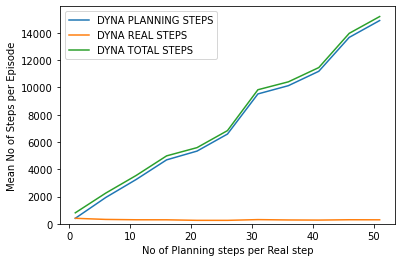

In [5]:
plt.plot([i for i in range(1,52,5)],ps[0:],label = 'DYNA PLANNING STEPS')
plt.plot([i for i in range(1,52,5)],rs[0:],label = 'DYNA REAL STEPS')
plt.plot([i for i in range(1,52,5)],ts[0:],label = 'DYNA TOTAL STEPS')
plt.xlabel('No of Planning steps per Real step')
plt.legend()
plt.ylim(bottom = 0)
plt.ylabel('Mean No of Steps per Episode')
plt.savefig('MountainCarDynaSteps.png')

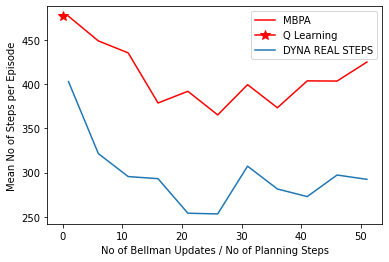

In [6]:
plt.plot([i for i in range(1,52,5)], step[0:],label = 'MBPA',color = 'red')
plt.plot(step[0],marker = '*', markersize = 10, color = 'red',label = 'Q Learning')
plt.plot([i for i in range(1,52,5)],rs[0:],label = 'DYNA REAL STEPS')
plt.xlabel('No of Bellman Updates / No of Planning Steps')
plt.legend()
plt.ylabel('Mean No of Steps per Episode')
plt.savefig('MountainCarSteps.png')

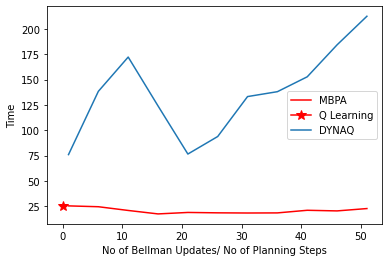

In [7]:

plt.plot([i for i in range(1,52,5)], tmbpa[0:],label = 'MBPA',color = 'red')
plt.plot(tmbpa[0],marker = '*', markersize = 10, color = 'red',label = 'Q Learning')
plt.plot([i for i in range(1,52,5)],td[0:],label = 'DYNAQ')
plt.xlabel('No of Bellman Updates/ No of Planning Steps')
plt.legend()
plt.ylabel('Time')
plt.savefig('MountainCarTime.png')